<a href="https://colab.research.google.com/github/2303a52163/EXPLAINABLE-AI-LAB/blob/main/XAI_LAB_ASSIGNMENT_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wine Quality (Multiclass Classification)**

# **LIBRARIES**

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
!pip install lime

import shap
from lime.lime_tabular import LimeTabularExplainer

# **Load dataset**

In [108]:
df = pd.read_csv("/content/wine_data.csv")
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,11.6,0.580,0.66,2.20,0.074,10.0,47.0,1.00080,3.25,0.57,9.0,3
1,10.4,0.610,0.49,2.10,0.200,5.0,16.0,0.99940,3.16,0.63,8.4,3
2,7.4,1.185,0.00,4.25,0.097,5.0,14.0,0.99660,3.63,0.54,10.7,3
3,10.4,0.440,0.42,1.50,0.145,34.0,48.0,0.99832,3.38,0.86,9.9,3
4,8.3,1.020,0.02,3.40,0.084,6.0,11.0,0.99892,3.48,0.49,11.0,3


# **Droping lable & Scale features**

In [112]:
X = df.drop(columns=["quality"])
y = df["quality"]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# **Train/test split**

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Encode categorical variables**

In [ ]:
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])

# **Train Logistic Regression**

In [97]:
model = LogisticRegression(max_iter=500,multi_class="multinomial", solver="lbfgs", random_state=42)
model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=500, multi_class='multinomial', random_state=42)

# **Permutation Importance**

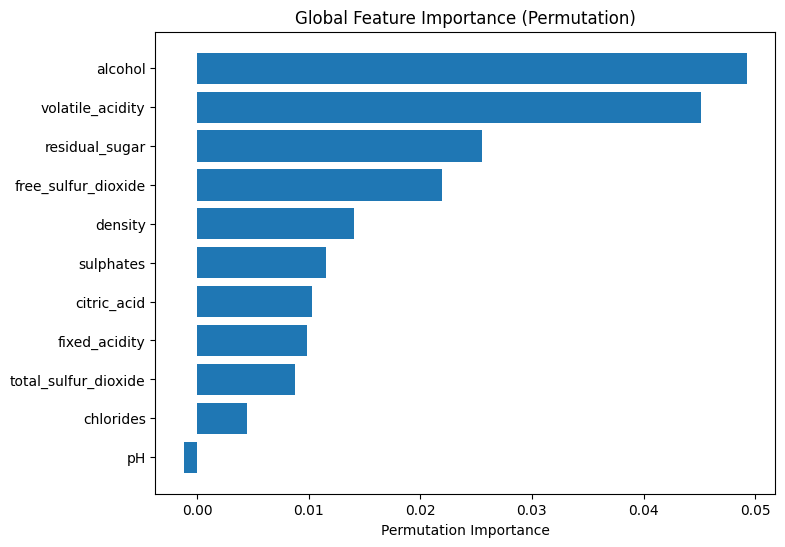

In [98]:
perm = permutation_importance(model, X_test_scaled, y_test, n_repeats=20, random_state=42)
sorted_idx = perm.importances_mean.argsort()

plt.figure(figsize=(8,6))
plt.barh(np.array(X.columns)[sorted_idx], perm.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Global Feature Importance (Permutation)")
plt.show()

# **SHAP Explanations**

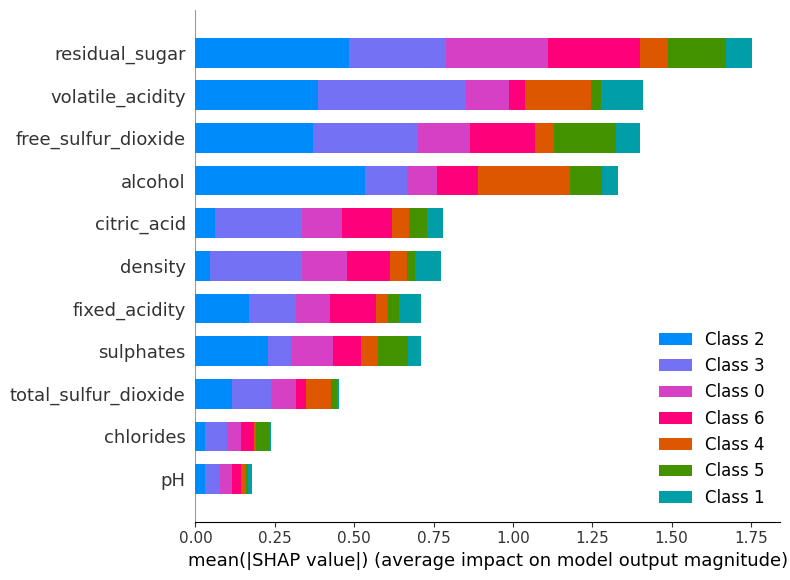

In [110]:
explainer = shap.LinearExplainer(model, X_train_scaled, feature_names=X.columns)
shap_values = explainer(X_test_scaled)

# Global summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

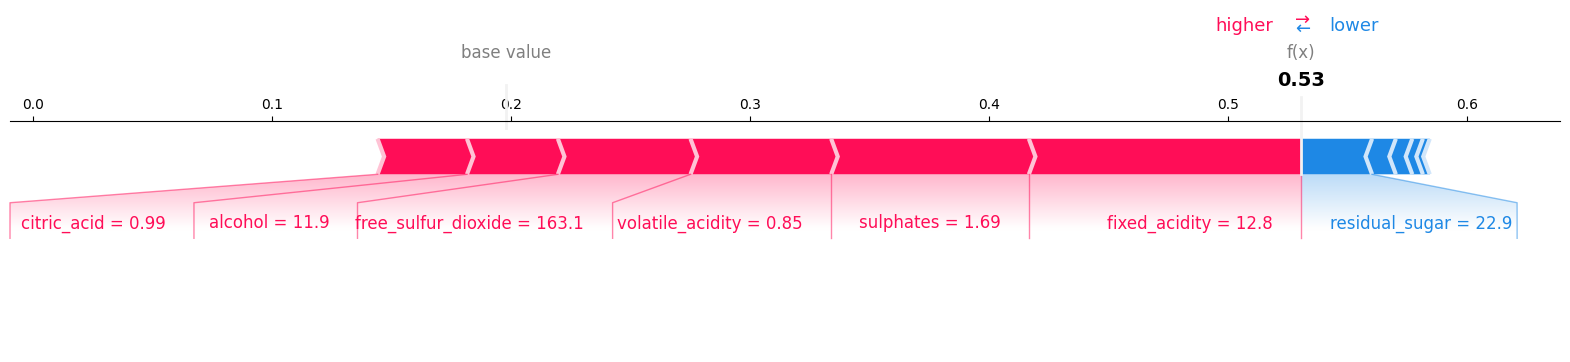

In [100]:
sample_idx = 0
class_idx = 1
shap.initjs()
shap.force_plot(
    explainer.expected_value[class_idx],
    shap_values.values[sample_idx, :, class_idx],
    X_test.iloc[sample_idx, :],
    feature_names=X.columns,
    matplotlib=True
)

# **LIME (Local Explanations)**

LIME explanation for sample 0 (True Class: class_0)


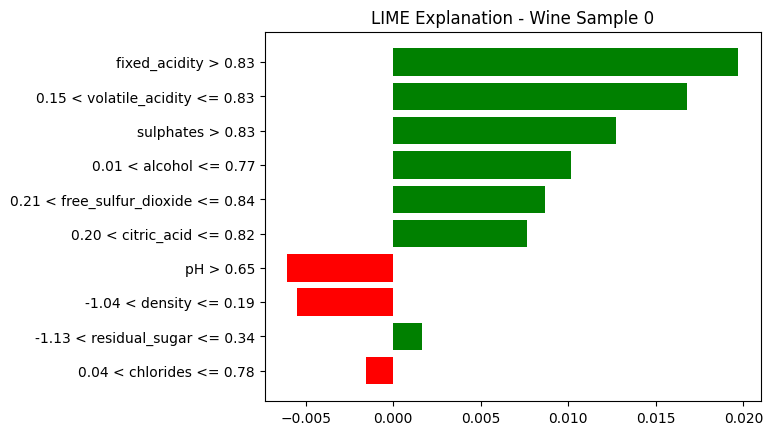

LIME explanation for sample 1 (True Class: class_2)


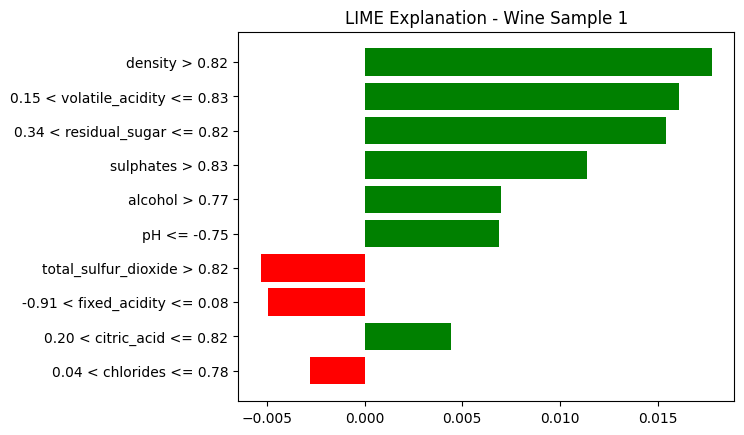

In [101]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train_scaled),
    feature_names=feature_names,
    class_names=class_names,
    mode="classification"
)

# Explain 2 wine samples
wine_idx_1 = 0
wine_idx_2 = 1

exp1 = lime_explainer.explain_instance(
    X_test_scaled[wine_idx_1],
    model.predict_proba,
    num_features=10
)
exp2 = lime_explainer.explain_instance(
    X_test_scaled[wine_idx_2],
    model.predict_proba,
    num_features=10
)

exp1.as_pyplot_figure()
print("LIME explanation for sample 0 (True Class: class_0)")
plt.title(f"LIME Explanation - Wine Sample {wine_idx_1}")
plt.show()

exp2.as_pyplot_figure()
print("LIME explanation for sample 1 (True Class: class_2)")
plt.title(f"LIME Explanation - Wine Sample {wine_idx_2}")
plt.show()

# **Comparison**

In [107]:
def clean_lime_feature_name(feat_str):
    return feat_str.split()[0]

# Sample 0
lime_scores_list_sample0 = exp1.as_list()
lime_scores_dict_sample0 = {clean_lime_feature_name(f): s for f, s in lime_scores_list_sample0}
lime_scores_sample0 = np.array([lime_scores_dict_sample0.get(f, 0) for f in X.columns[sorted_idx]])

# Sample 1
lime_scores_list_sample1 = exp2.as_list()
lime_scores_dict_sample1 = {clean_lime_feature_name(f): s for f, s in lime_scores_list_sample1}
lime_scores_sample1 = np.array([lime_scores_dict_sample1.get(f, 0) for f in X.columns[sorted_idx]])

# Comparison DataFrame
comparison = pd.DataFrame({
    "Permutation Importance": pi_scores,
    "SHAP (mean abs values)": shap_scores,
    "LIME (sample 0)": lime_scores_sample0,
    "LIME (sample 1)": lime_scores_sample1
}, index=X.columns[sorted_idx])

# Normalize
comparison_norm = comparison.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

print("\n=== Comparative Feature Importance ===\n")
print(comparison_norm.sort_values("SHAP (mean abs values)", ascending=False).round(3))



=== Comparative Feature Importance ===

                      Permutation Importance  SHAP (mean abs values)  \
fixed_acidity                          0.220                   1.000   
chlorides                              0.112                   0.781   
sulphates                              0.254                   0.777   
alcohol                                1.000                   0.733   
total_sulfur_dioxide                   0.198                   0.382   
free_sulfur_dioxide                    0.459                   0.378   
pH                                     0.000                   0.339   
volatile_acidity                       0.918                   0.338   
density                                0.302                   0.174   
citric_acid                            0.227                   0.038   
residual_sugar                         0.530                   0.000   

                      LIME (sample 0)  LIME (sample 1)  
fixed_acidity                   1.000